In [ ]:
%matplotlib inline


# Harmonic-percussive source separation


This notebook illustrates how to separate an audio signal into
its harmonic and percussive components.

We'll compare the original median-filtering based approach of
`Fitzgerald, 2010 <http://arrow.dit.ie/cgi/viewcontent.cgi?article=1078&context=argcon>`_
and its margin-based extension due to `Dreidger, Mueller and Disch, 2014
<http://www.terasoft.com.tw/conf/ismir2014/proceedings/T110_127_Paper.pdf>`_.





In [9]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio

Load the example clip.



In [2]:
mp3_url = 'https://p.scdn.co/mp3-preview/51dda7a781e64464d832e4f1f5b963146a6e09bb?cid=5157426229ce47aea8e1a6c56e231ddf'

import urllib.request
from os import path
from pydub import AudioSegment

def load_mp3_from_url(mp3_url, mp3_path = "temp.mp3", wav_path = "wav.mp3", duration = None):
    
    # retreive audio from url and save
    urllib.request.urlretrieve(mp3_url, mp3_path)

    # files                                                                         
    src = mp3_path
    dst = wav_path

    # convert mp3 to wav                                                            
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

    y, sr = librosa.load(wav_path, duration = duration)
    
    return y, sr

y, sr = load_mp3_from_url(mp3_url)


In [ ]:
y, sr = librosa.load('audio/Karissa_Hobbs_-_09_-_Lets_Go_Fishin.mp3', offset=40, duration=10)

Compute the short-time Fourier transform of y



In [3]:
D = librosa.stft(y)

Decompose D into harmonic and percussive components

$D = D_\text{harmonic} + D_\text{percussive}$



In [4]:
D_harmonic, D_percussive = librosa.decompose.hpss(D)

We can plot the two components along with the original spectrogram



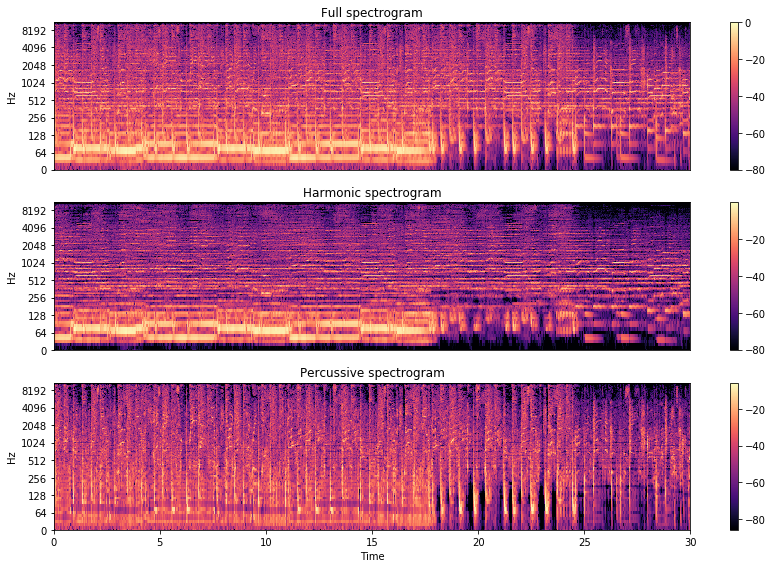

In [5]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

The default HPSS above assigns energy to each time-frequency bin according to
whether a horizontal (harmonic) or vertical (percussive) filter responds higher
at that position.

This assumes that all energy belongs to either a harmonic or percussive source,
but does not handle "noise" well.  Noise energy ends up getting spread between
D_harmonic and D_percussive.

If we instead require that the horizontal filter responds more than the vertical
filter *by at least some margin*, and vice versa, then noise can be removed
from both components.

Note: the default (above) corresponds to margin=1



In [6]:
# Let's compute separations for a few different margins and compare the results below
D_harmonic2, D_percussive2 = librosa.decompose.hpss(D, margin=2)
D_harmonic4, D_percussive4 = librosa.decompose.hpss(D, margin=4)
D_harmonic8, D_percussive8 = librosa.decompose.hpss(D, margin=8)
D_harmonic16, D_percussive16 = librosa.decompose.hpss(D, margin=16)

In the plots below, note that vibrato has been suppressed from the harmonic
components, and vocals have been suppressed in the percussive components.



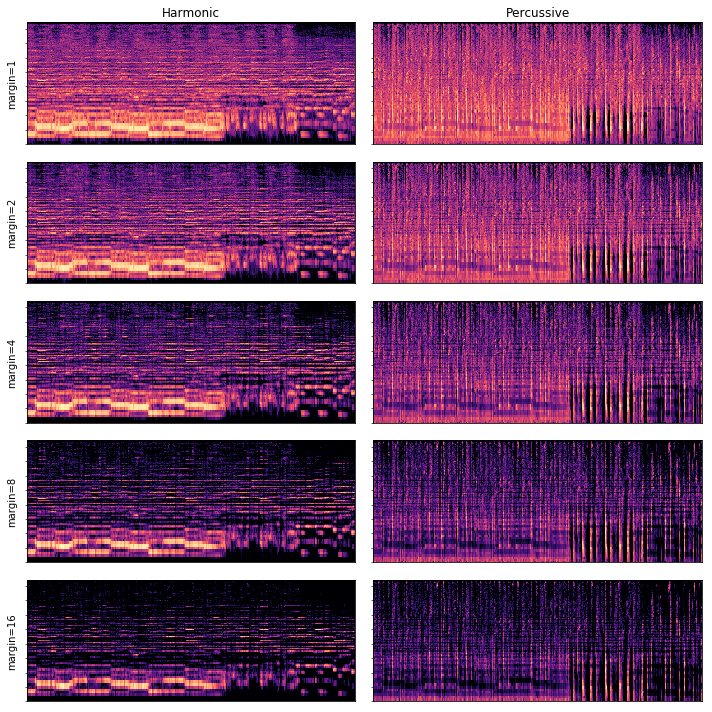

In [7]:
plt.figure(figsize=(10, 10))

plt.subplot(5, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), y_axis='log')
plt.title('Harmonic')
plt.yticks([])
plt.ylabel('margin=1')

plt.subplot(5, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), y_axis='log')
plt.title('Percussive')
plt.yticks([]), plt.ylabel('')

plt.subplot(5, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic2), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=2')

plt.subplot(5, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive2), ref=rp), y_axis='log')
plt.yticks([]) ,plt.ylabel('')

plt.subplot(5, 2, 5)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic4), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=4')

plt.subplot(5, 2, 6)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive4), ref=rp), y_axis='log')
plt.yticks([]), plt.ylabel('')

plt.subplot(5, 2, 7)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic8), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=8')

plt.subplot(5, 2, 8)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive8), ref=rp), y_axis='log')
plt.yticks([]), plt.ylabel('')

plt.subplot(5, 2, 9)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic16), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=16')

plt.subplot(5, 2, 10)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive16), ref=rp), y_axis='log')
plt.yticks([]), plt.ylabel('')

plt.tight_layout()
plt.show()

In [17]:
Audio(librosa.core.istft(D_harmonic8), rate = sr)

In [18]:
Audio(librosa.core.istft(D_percussive8), rate = sr)

In [19]:
Audio(librosa.core.istft(D_percussive8) + librosa.core.istft(D_harmonic8), rate = sr)

In [30]:
Audio(y, rate = sr)

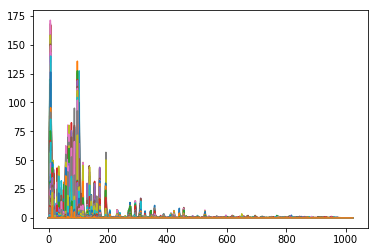

In [29]:
for i in range(D_harmonic8.shape[1]):
    plt.plot(np.abs(D_harmonic8[:,i]))

In [28]:
D_harmonic8.shape

(1025, 1292)